In [1]:
from time import sleep
import serial
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Connect to the Arduino
This Arduino (Metro Mini) always connects as '/dev/ttyUSB#'

In [2]:
ser = None
connected = False
for port in range(8):
    try:
        ser = serial.Serial('/dev/ttyUSB%d' % port, 115200) # Establish the connection on a specific port
        connected = True
        print("Connected to device at /dev/ttyUSB%d" % port)
        break
    except:
        continue
if not connected:
    print("Failed to connect")

Connected to device at /dev/ttyUSB0


# Read Force Array
This function sends the initialization message "go\n",
which tells the Arduino to start scanning the force array.

The force array is a 5x6 array of resistor dividers,
with the velostat acting as a variable resistor and one 5k ohm resistor to ground.
The Arduino does a 10-bit analog read (this tends to be around 100-200 units for this resistor setup)
on each of the five rows with only one of the six columns on at a time. This technique is known as *multiplexing*.

In [3]:
def read_force_array():
    ser.write(b"go\n")
    arr = []
    for i_col in range(6):
        instr = ser.readline()
        row = list(map(int, instr.split(b" ")[:-1]))
        arr.append(row)
    byte = ser.readline()
    return arr

# Calibration
The force mesh array can be calibrated by reading it over many samples and finding the average and standard deviation for each resistor divider. This is then used to adjust the raw readings by the sensor in *adjust_range* below.

## Calibrate Initial
The initial calibration is just multiple samples done without attempting to assign a "true value" to the reading. This is the so called **S1** from control chart theory, as it defines the baseline for the rest of the run.

## Calibrate From History
This adjusts the calibration array during a run, by using the mean and standard deviation from the *ctrl_hist* object. This has a specific *memory*, so it can adjust the mean and stdev on the fly and account for the lag in deformation in the Velostat material

In [4]:
def calibrate_initial(num_samples=1):
    samples = []
    for n in range(num_samples):
        samples.append(read_force_array())
        sleep(.1)
    
    calib = [[0 for row in range(5)] for col in range(6)]
    for col in range(6):
        for row in range(5):
            cell_sample = [sample[col][row] for sample in samples]
            mean = np.mean(cell_sample)
            stdev = np.std(cell_sample)+1
            calib[col][row] = (mean, stdev)
    return calib

def calibrate_from_history(hist):
    new_calib = [[None for row in range(5)] for col in range(6)]
    for col in range(6):
        for row in range(5):
            mean = hist["u"][col][row][-1]
            stdev = hist["s"][col][row][-1]+1
            new_calib[col][row] = (mean, stdev)
    return new_calib

# Adjust Range
This function takes in the raw array for a single reading from the force array and uses the calibration array to rescale it based on the mean and standard deviation of each resistor divider. This gives the z-scores of each sensor and this can then be scaled up and shifted to whatever center and spread desired using the *mu* and *std* params. This makes the readings approximately uniform across the sensor (as long as the calibration is done well).

In [5]:
def adjust_range(arr, calib, mu=50, std=10):
    ret = [[0 for row in range(5)] for col in range(6)]
    for col in range(6):
        for row in range(5):
            cell_mu, cell_std = calib[col][row]
            cell = arr[col][row]
            z = (cell - cell_mu) / cell_std
            ret[col][row] = z * std + mu
    return ret

# Update Control Chart
This function takes the most recent force sensor readings and updates the *ctrl_hist* history of the control chart for displaying and updating the calibration.

In [6]:
def update_ctrl_chart(recent_arr, hist, memory=20):
    hist["t"].append(len(hist["t"]))
    for col in range(6):
        for row in range(5):
            hist["x"][col][row].append(recent_arr[col][row])
            
            mem = hist["x"][col][row][-memory:]
            hist["u"][col][row].append(np.mean(mem))
            hist["s"][col][row].append(np.std(mem))
    return hist

# Testing Loop
This is the main loop for testing and using the force sensor array.
It maintains a *ctrl_hist* object that stores the history of the 
sample values, means, and stdevs at different points in time t.

It also dynamically updates the calibration array so that it can
correctly adjust the raw input array to get a more balanced set of readings for each sample.

This displays a heatmap representing the sensor, with an interpolation filter applied.
(Change *'lanczos'* to *'nearest'* to see the values on the individual sensors)
It also displays the control chart, showing the mean (orange line)
and standard deviation around the mean (blue highlighted),
as well as the current raw sample reading (blue line).

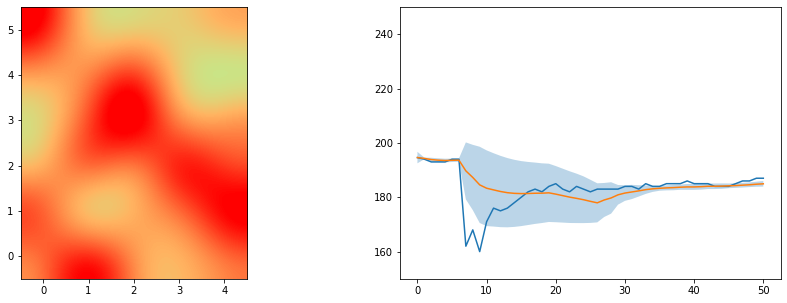

In [16]:
ctrl_hist = {
    "t": None,
    "x": [[None for row in range(5)] for col in range(6)],
    "u": [[None for row in range(5)] for col in range(6)],
    "s": [[None for row in range(5)] for col in range(6)]
}
print("Calibrating...")
calib_arr = calibrate_initial(10)
for col in range(6):
    for row in range(5):
        mu, std = calib_arr[col][row]
        ctrl_hist["t"] = [0]
        ctrl_hist["x"][col][row] = [mu]
        ctrl_hist["u"][col][row] = [mu]
        ctrl_hist["s"][col][row] = [std]

while True:
    raw_arr = read_force_array()
    arr = adjust_range(raw_arr, calib_arr)
    ctrl_hist = update_ctrl_chart(raw_arr, ctrl_hist)
    calib_arr = calibrate_from_history(ctrl_hist)
    
    fig, (ax_arrheat, ax_ctrl) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Draw Heatmap
    ax_arrheat.imshow([list(reversed(col)) for col in arr], 
                      cmap='rainbow', interpolation='lanczos', 
                      vmin=0, vmax=60, origin='lower')
    
    # Draw Control Chart
    ax_ctrl.plot(ctrl_hist["t"], ctrl_hist["x"][3][2])
    ax_ctrl.plot(ctrl_hist["t"], ctrl_hist["u"][3][2])
    ax_ctrl.fill_between(ctrl_hist["t"], [u - s for u, s in zip(ctrl_hist["u"][3][2], ctrl_hist["s"][3][2])], 
                         [u + s for u, s in zip(ctrl_hist["u"][3][2], ctrl_hist["s"][3][2])], alpha='.3')
    ax_ctrl.set_ylim((150, 250))
    
    clear_output(wait=True)
    plt.show()
